In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = sorted([290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 
                      290375, 291399, 291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 
                      290932, 290423, 291447, 290935, 290425, 290427, 291451, 291453, 291976, 291982, 
                      290456, 290458, 290459, 291482, 291485, 290975, 290980, 290469, 292012, 291002, 
                      291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 291041, 290539, 
                      290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
                      292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 
                      292164, 292166, 290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 
                      291694, 291698, 291706, 290687, 290692, 290696, 290699, 292242, 292265, 291755, 
                      292269, 292270, 291760, 292273, 292274, 290742, 291769, 291263, 290764, 290766, 
                      291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787])

# "run", "duration(s)", "weight"
runDurationWeight = [
       [2.90323000e+05, 8.56300000e+03, 4.66826582e-01],
       [2.90327000e+05, 7.39000000e+02, 4.02878482e-02],
       [2.90374000e+05, 4.40500000e+03, 2.40146105e-01],
       [2.90375000e+05, 2.04400000e+03, 1.11432154e-01],
       [2.90404000e+05, 8.31600000e+03, 4.53360955e-01],
       [2.90423000e+05, 3.55900000e+03, 1.94024969e-01],
       [2.90425000e+05, 9.90000000e+03, 5.39715423e-01],
       [2.90427000e+05, 3.08800000e+03, 1.68347599e-01],
       [2.90456000e+05, 1.58600000e+03, 8.64635011e-02],
       [2.90458000e+05, 1.31700000e+03, 7.17985062e-02],
       [2.90459000e+05, 1.57770000e+04, 8.60110124e-01],
       [2.90469000e+05, 9.96900000e+03, 5.43477076e-01],
       [2.90501000e+05, 1.66300000e+04, 9.06612877e-01],
       [2.90539000e+05, 4.78000000e+03, 2.60589871e-01],
       [2.90540000e+05, 4.22700000e+03, 2.30442131e-01],
       [2.90549000e+05, 7.33900000e+03, 4.00098130e-01],
       [2.90553000e+05, 5.40000000e+03, 2.94390231e-01],
       [2.90590000e+05, 8.41600000e+03, 4.58812626e-01],
       [2.90612000e+05, 1.97900000e+03, 1.07888568e-01],
       [2.90632000e+05, 1.97200000e+03, 1.07506951e-01],
       [2.90658000e+05, 6.64000000e+02, 3.61990950e-02],
       [2.90660000e+05, 7.70300000e+03, 4.19942212e-01],
       [2.90687000e+05, 9.70200000e+03, 5.28921114e-01],
       [2.90692000e+05, 1.30230000e+04, 7.09971106e-01],
       [2.90696000e+05, 5.12300000e+03, 2.79289102e-01],
       [2.90699000e+05, 4.18100000e+03, 2.27934362e-01],
       [2.90742000e+05, 1.32080000e+04, 7.20056697e-01],
       [2.90764000e+05, 3.22000000e+03, 1.75543804e-01],
       [2.90766000e+05, 4.41400000e+03, 2.40636755e-01],
       [2.90776000e+05, 4.07800000e+03, 2.22319141e-01],
       [2.90787000e+05, 3.84600000e+03, 2.09671264e-01],
       [2.90848000e+05, 8.88400000e+03, 4.84326446e-01],
       [2.90853000e+05, 4.53600000e+03, 2.47287794e-01],
       [2.90860000e+05, 1.56670000e+04, 8.54113286e-01],
       [2.90894000e+05, 2.59700000e+03, 1.41579894e-01],
       [2.90895000e+05, 1.20100000e+03, 6.54745680e-02],
       [2.90932000e+05, 4.52100000e+03, 2.46470043e-01],
       [2.90935000e+05, 3.60600000e+03, 1.96587254e-01],
       [2.90975000e+05, 8.47200000e+03, 4.61865562e-01],
       [2.90980000e+05, 1.48200000e+03, 8.07937633e-02],
       [2.91002000e+05, 1.24070000e+04, 6.76388813e-01],
       [2.91003000e+05, 8.03600000e+03, 4.38096277e-01],
       [2.91004000e+05, 1.20280000e+04, 6.55726980e-01],
       [2.91005000e+05, 3.92500000e+03, 2.13978084e-01],
       [2.91041000e+05, 1.27710000e+04, 6.96232895e-01],
       [2.91263000e+05, 1.83430000e+04, 1.00000000e+00],
       [2.91283000e+05, 3.75400000e+03, 2.04655727e-01],
       [2.91284000e+05, 7.89300000e+03, 4.30300387e-01],
       [2.91285000e+05, 1.44100000e+03, 7.85585782e-02],
       [2.91360000e+05, 1.03470000e+04, 5.64084392e-01],
       [2.91361000e+05, 2.23000000e+03, 1.21572262e-01],
       [2.91362000e+05, 7.90000000e+03, 4.30682004e-01],
       [2.91373000e+05, 1.48900000e+03, 8.11753803e-02],
       [2.91399000e+05, 4.59800000e+03, 2.50667830e-01],
       [2.91400000e+05, 3.81600000e+03, 2.08035763e-01],
       [2.91447000e+05, 5.71700000e+03, 3.11672027e-01],
       [2.91451000e+05, 3.60300000e+03, 1.96423704e-01],
       [2.91453000e+05, 1.36800000e+04, 7.45788584e-01],
       [2.91482000e+05, 8.73400000e+03, 4.76148940e-01],
       [2.91485000e+05, 1.71300000e+03, 9.33871232e-02],
       [2.91590000e+05, 6.83300000e+03, 3.72512675e-01],
       [2.91618000e+05, 5.82100000e+03, 3.17341765e-01],
       [2.91622000e+05, 5.78100000e+03, 3.15161097e-01],
       [2.91624000e+05, 9.84100000e+03, 5.36498937e-01],
       [2.91657000e+05, 4.46900000e+03, 2.43635174e-01],
       [2.91690000e+05, 1.98500000e+03, 1.08215668e-01],
       [2.91692000e+05, 3.61200000e+03, 1.96914354e-01],
       [2.91694000e+05, 3.91900000e+03, 2.13650984e-01],
       [2.91698000e+05, 4.35600000e+03, 2.37474786e-01],
       [2.91706000e+05, 7.37700000e+03, 4.02169765e-01],
       [2.91755000e+05, 6.47400000e+03, 3.52941176e-01],
       [2.91760000e+05, 6.94000000e+02, 3.78345963e-02],
       [2.91769000e+05, 7.75400000e+03, 4.22722564e-01],
       [2.91795000e+05, 1.30600000e+03, 7.11988224e-02],
       [2.91796000e+05, 1.74900000e+03, 9.53497247e-02],
       [2.91803000e+05, 2.36000000e+03, 1.28659434e-01],
       [2.91943000e+05, 8.53400000e+03, 4.65245598e-01],
       [2.91944000e+05, 4.97100000e+03, 2.71002562e-01],
       [2.91948000e+05, 9.12000000e+03, 4.97192389e-01],
       [2.91953000e+05, 1.39490000e+04, 7.60453579e-01],
       [2.91976000e+05, 8.14600000e+03, 4.44093115e-01],
       [2.91982000e+05, 5.97900000e+03, 3.25955405e-01],
       [2.92012000e+05, 6.48200000e+03, 3.53377310e-01],
       [2.92040000e+05, 8.80600000e+03, 4.80074143e-01],
       [2.92060000e+05, 6.13800000e+03, 3.34623562e-01],
       [2.92061000e+05, 4.21100000e+03, 2.29569863e-01],
       [2.92062000e+05, 1.29990000e+04, 7.08662705e-01],
       [2.92075000e+05, 7.79700000e+03, 4.25066783e-01],
       [2.92077000e+05, 3.60700000e+03, 1.96641771e-01],
       [2.92080000e+05, 5.63800000e+03, 3.07365207e-01],
       [2.92106000e+05, 4.59700000e+03, 2.50613313e-01],
       [2.92108000e+05, 3.84700000e+03, 2.09725781e-01],
       [2.92109000e+05, 3.63000000e+03, 1.97895655e-01],
       [2.92115000e+05, 1.12640000e+04, 6.14076214e-01],
       [2.92140000e+05, 6.87000000e+02, 3.74529793e-02],
       [2.92160000e+05, 1.53940000e+04, 8.39230224e-01],
       [2.92162000e+05, 8.22000000e+02, 4.48127351e-02],
       [2.92163000e+05, 4.39200000e+03, 2.39437388e-01],
       [2.92164000e+05, 9.90000000e+02, 5.39715423e-02],
       [2.92166000e+05, 3.44800000e+03, 1.87973614e-01],
       [2.92168000e+05, 6.40300000e+03, 3.49070490e-01],
       [2.92192000e+05, 7.83000000e+02, 4.26865834e-02],
       [2.92242000e+05, 3.08000000e+03, 1.67911465e-01],
       [2.92265000e+05, 2.73000000e+03, 1.48830617e-01],
       [2.92269000e+05, 1.13700000e+03, 6.19854986e-02],
       [2.92270000e+05, 3.69800000e+03, 2.01602791e-01],
       [2.92273000e+05, 1.04010000e+04, 5.67028294e-01],
       [2.92274000e+05, 4.35400000e+03, 2.37365753e-01]]

In [50]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksEvents(events):
    return ak.zip({
        "px":events["Muon_Px"],
        "py":events["Muon_Py"],
        "pz":events["Muon_Pz"],
        "E":events["Muon_E"],
        "charge":events["Muon_Charge"],
        "thetaAbs":events["Muon_thetaAbs"],
        "matched":events["Muon_matchedTrgThreshold"],
        "code":events["Muon_MCPDGCode"],
        "label":events["Muon_MCLabel"]},
         with_name='Momentum4D')

def getTracksGen(events):
    return ak.zip({
        "px":events["Muon_GenPx"],
        "py":events["Muon_GenPy"],
        "pz":events["Muon_GenPz"],
        "E":events["Muon_GenE"],
        "label":events["Muon_GenLabel"],
        "code":events["Muon_GenMotherPDGCode"]},
        with_name='Momentum4D')

def Momentum4D(events):
    return ak.zip({
        "px": events["0"].px + events["1"].px,
        "py": events["0"].py + events["1"].py,
        "pz": events["0"].pz + events["1"].pz,
        "E" : events["0"].E  + events["1"].E},
        with_name="Momentum4D")


def scan(dataDescription, 
              hMagGen:hist.Hist, hPhiGen:hist.Hist, hEtaGen:hist.Hist, hYGen:hist.Hist, hPtGen:hist.Hist, hMassGen:hist.Hist, hMass2Gen:hist.Hist,
              hMagEvents:hist.Hist, hPhiEvents:hist.Hist, hEtaEvents:hist.Hist, hYEvents:hist.Hist, hPtEvents:hist.Hist, hMassEvents:hist.Hist, hMass_OSMuon:hist.Hist, hMass_LSMuon:hist.Hist,
              eventSelectorGen = lambda x:[True]*len(x), trackSelectorGen = lambda x:[True]*len(x),
              eventSelectorEvents = lambda x:[True]*len(x), trackSelectorEvents = lambda x:[True]*len(x),
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    nEntriesGen = nGoodEventsGen = nGoodTracksGen = nGoodEntriesGen = nJPsi = nPairsGen = 0
    PDGGen = PDG = LabelGen = Label = []
    nEntries = nGoodEvents = nGoodTracks = nGoodEntries = AxE = nPairs = nOS = nLS = 0
    
    for batchGen, batchEvents in zip(uproot.iterate(dataDescription + "genTree", ["Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel", "Muon_GenMotherPDGCode"], report = True),
                                    uproot.iterate(dataDescription + "eventsTree", ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", "Muon_thetaAbs", "Muon_matchedTrgThreshold", "Muon_MCLabel", "Muon_MCPDGCode"], report = True)):

        eventsGen = batchGen[0] # batch[1] is the report info
        events = batchEvents[0]
        #eventsGen[0:10].show()
        #events[0:10].show()

        if (len(eventsGen) < 1000) | (len(events) < 1000):
            print("something is wrong", batchGen[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEventsGen = eventsGen[eventSelectorGen(eventsGen)]
        tracksGen = getTracksGen(goodEventsGen)
        goodTracksGen = tracksGen[trackSelectorGen(tracksGen)]
        #goodTracksGen[0:10].show()
        
        hMagGen.fill(ak.flatten(goodTracksGen.p))
        hPhiGen.fill(ak.flatten(goodTracksGen.phi))
        hPtGen.fill(ak.flatten(goodTracksGen.pt))
        hYGen.fill(ak.flatten(goodTracksGen.rapidity))
        hEtaGen.fill(ak.flatten(goodTracksGen.eta))
        hMassGen.fill(ak.flatten(goodTracksGen.mass))
        
        pairsGen = ak.combinations(goodTracksGen, 2)
        Gen = Momentum4D(pairsGen)
        
        hMass2Gen.fill(ak.flatten(Gen.mass))
        
        
        
        isJPsi = ak.num(goodTracksGen) == 2
        #print(isJPsi[0:10].show())
        events2 = ak.zip({"isJPsi":isJPsi, "isCINT":events["isCINT"], "isCMUL":events["isCMUL"], "isCMSL":events["isCMSL"], "Muon_Px":events["Muon_Px"], "Muon_Py":events["Muon_Py"], 
                          "Muon_Pz":events["Muon_Pz"], "Muon_E":events["Muon_E"], "Muon_Charge":events["Muon_Charge"], "Muon_thetaAbs":events["Muon_thetaAbs"],
                          "Muon_matchedTrgThreshold":events["Muon_matchedTrgThreshold"], "Muon_MCLabel":events["Muon_MCLabel"], "Muon_MCPDGCode":events["Muon_MCPDGCode"]})
                          
        
        #print(events2[0:10].show())
        goodEvents = events2[eventSelectorEvents(events2)]
        tracks = getTracksEvents(goodEvents)
        goodTracks = tracks[trackSelectorEvents(tracks)]
        #goodTracks[0:10].show()
        
        
        pairs = ak.combinations(goodTracks, 2)
        
        
        condition_OS = np.logical_or(np.logical_and(pairs["0"].code ==  13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code == -13, pairs["1"].code ==  13))
        muons_OS = pairs[condition_OS]
        OS = Momentum4D(muons_OS)
    
        
        condition_LS = np.logical_or(np.logical_and(pairs["0"].code == -13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code ==  13, pairs["1"].code ==  13))
        muons_LS = pairs[condition_LS]
        LS = Momentum4D(muons_LS)

        
        hMagEvents.fill(ak.flatten(goodTracks.p))
        hPhiEvents.fill(ak.flatten(goodTracks.phi))
        hPtEvents.fill(ak.flatten(goodTracks.pt))
        hYEvents.fill(ak.flatten(goodTracks.rapidity))
        hEtaEvents.fill(ak.flatten(goodTracks.eta))
        hMassEvents.fill(ak.flatten(goodTracks.mass))
        
        hMass_OSEvents.fill(ak.flatten(OS.mass))
        hMass_LSEvents.fill(ak.flatten(LS.mass))
        
        
        nEntriesGen += len(eventsGen)
        nGoodEventsGen += len(goodEventsGen)
        nGoodTracksGen += len(ak.flatten(goodTracks))
        nGoodEntriesGen += list(ak.num(goodTracksGen) == 2).count(True)
        nJPsi += list(isJPsi).count(True)
        nPairsGen += len(ak.flatten(pairsGen))
        PDGGen = np.union1d(PDG, ak.flatten(goodTracksGen.code))
        LabelGen = np.union1d(LabelGen, ak.flatten(goodTracksGen.label))
        
        nEntries += len(events)
        nGoodEvents += len(goodEvents)
        nGoodTracks += len(ak.flatten(goodTracks))
        nGoodEntries += list(ak.num(goodTracks) == 2).count(True)
        nPairs += len(ak.flatten(pairs))
        nOS += len(ak.flatten(OS))
        nLS += len(ak.flatten(LS))
        PDG = np.union1d(PDG, ak.flatten(goodTracks.code))
        Label = np.union1d(Label, ak.flatten(goodTracks.label))
        
        AxE = nGoodEntries / nJPsi

        if verbose:
            #print("Statistiques Generees")
            print(batchGen[1])
            print("Entries: ", nEntries)
            #print("Good Events: ", nGoodEventsGen)
            #print("Good Tracks: ", nGoodTracksGen)
            #print("Good Entries: ", nGoodEntriesGen)
            print("J/Psi: ", nJPsi)
            #print("Pairs: ", nPairsGen)
            print("PDG: ", PDGGen)
            print("Label: ", LabelGen)
            print("----------------------------")
            
            #print("Statistiques Detectees")
            print(batchEvents[1])
            print("Entries: ", nEntries)
            #print("Good Events: ", nGoodEvents)
            #print("Good Tracks: ", nGoodTracks)
            print("Good Entries: ", nGoodEntries)
            #print("Pairs: ", nPairs)
            print("OS: ", nOS)
            #print("LS: ", nLS)
            print("PDG: ", PDG)
            print("Label: ", Label)
            #print("-------> AxE: ", AxE)
            print("---------------------------------------------------------------------------------------")
        gc.collect()
        
    return nEntriesGen, nGoodEventsGen, nGoodTracksGen, nGoodEntriesGen, nJPsi, nPairsGen, PDGGen, nEntries, nGoodEvents, nGoodTracks, nGoodEntries, nPairs, nOS, nLS, PDG, AxE, LabelGen, Label

In [72]:
%%time

hMagGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiGen = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEtaGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hYGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPtGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMassGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hMass2Gen = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

hMagEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiEvents = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEtaEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hYEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPtEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMassEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hMass_OSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

EntriesGen = goodEventsGen = goodTracksGen = goodEntriesGen = JPsi = PairsGen = 0
PDGGen = PDG = LabelGen = Label = []
Entries = goodEvents = goodTracks = goodEntries = Pairs = OS = LS = 0
numerator = denominator = AxE = 0

runs = SAMPLE_RUNS
_ = pd.read_csv("../data/counters.online.csv")
target_columns = ["run", "duration(s)"]
runDurationWeight = _[target_columns]
filtered_runDurationWeight = runDurationWeight[runDurationWeight["run"].isin(runs)]
filtered_runDurationWeight = filtered_runDurationWeight.copy()
filtered_runDurationWeight["weight"] = filtered_runDurationWeight["duration(s)"] / filtered_runDurationWeight["duration(s)"].max()
filtered_runDurationWeight.values

for run, duration, weight in filtered_runDurationWeight.values:
    a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{int(run)}.mc.root:",
                                                                hMagGen = hMagGen, hPhiGen = hPhiGen, hEtaGen= hEtaGen, hYGen = hYGen, hPtGen = hPtGen, hMassGen = hMassGen, hMass2Gen = hMass2Gen,
                                                                hMagEvents = hMagEvents, hPhiEvents = hPhiEvents, hEtaEvents = hEtaEvents, hYEvents = hYEvents, hPtEvents = hPtEvents, hMassEvents = hMassEvents, hMass_OSMuon = hMass_OSEvents, hMass_LSMuon = hMass_LSEvents,
                                                                #eventSelectorGen = lambda x: ,
                                                                trackSelectorGen = lambda x: (x.code == 443),# & (x.eta < -2.5) & (x.eta > -4),# & (x.pt > 3) & (x.pt < 4),
                                                                eventSelectorEvents = lambda x: (x["isCMUL"] == True) & (x["isJPsi"] == True), 
                                                                trackSelectorEvents = lambda x: ((x.code == 13) | (x.code == -13)) & ((x.label == 1) | (x.label == 2)),# & (x.pt > 3) & (x.pt < 4) &
                                                                #(x.thetaAbs < 10) & (x.thetaAbs > 2) & (x.pt > 0.5) &
                                                                #(x.eta < -2.5) & (x.eta > -4),
                                                                verbose = True)
    
    EntriesGen += a
    goodEventsGen += b
    goodTracksGen += c
    goodEntriesGen += d
    JPsi += e
    PairsGen += f
    PDGGen = np.union1d(PDGGen, g)
    LabelGen = np.union1d(LabelGen, q)
    
    Entries += h
    goodEvents += i
    goodTracks += j
    goodEntries += k
    Pairs += l
    OS += m
    LS += n
    PDG = np.union1d(PDG, o)
    Label = np.union1d(Label, r)
    
    numerator += weight * p
    denominator += weight
    
    print("run: ", int(run))
    print("Duration(s): ", int(duration))
    print("Weight: ", weight)
    print("-------> AxE: ", p)
    print("---------------------------------------------------------------------------------------")
    
AxE = numerator / denominator

print("Entries: ", EntriesGen)
#print("Good Events: ", goodEventsGen)
#print("Good Tracks: ", goodTracksGen)
#print("Good Entries: ", goodEntriesGen)
print("J/Psi: ", JPsi)
#print("Pairs: ", PairsGen)
print("PDG: ", PDGGen)
print("Label: ", LabelGen)
print("----------------------------")
print("Entries: ", Entries)
#print("Good Events: ", goodEvents)
#print("Good Tracks: ", goodTracks)
print("Good Entries: ", goodEntries)
#print("Pairs: ", Pairs)
#print("OS: ", OS)
#print("LS: ", LS)
print("PDG: ", PDG)
print("Label: ", Label)
print("-------> AxE: ", AxE)
print("---------------------------------------------------------------------------------------")

<Report start=0 stop=70000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.mc.root:/genTree;1'>
Entries:  70000
J/Psi:  46507
PDG:  [443]
Label:  [1, 2]
----------------------------
<Report start=0 stop=70000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.mc.root:/eventsTree;1'>
Entries:  70000
Good Entries:  10008
OS:  10008
PDG:  [-13, 13]
Label:  [1, 2]
---------------------------------------------------------------------------------------
run:  290323
Duration(s):  8563
Weight:  0.4668265823474895
-------> AxE:  0.21519341174446857
---------------------------------------------------------------------------------------
<Report start=0 stop=6000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.mc.root:/genTree;1'>
Entries:  6000
J/Psi:  4020
PDG:  [443]
Label:  [1, 2]
----------------------------
<Report start=0 stop=6000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.mc.root:/eventsTree;1'>
Entries:  6000
Good Entries:  823
OS

In [6]:
print(AxE)

0


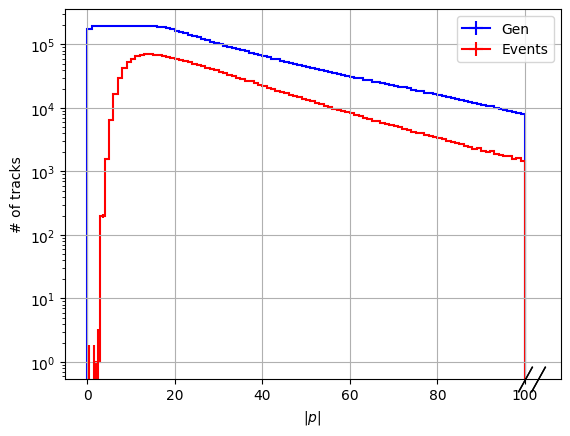

In [73]:
hMagGen.plot(color = "blue", label = "Gen")
hMagEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

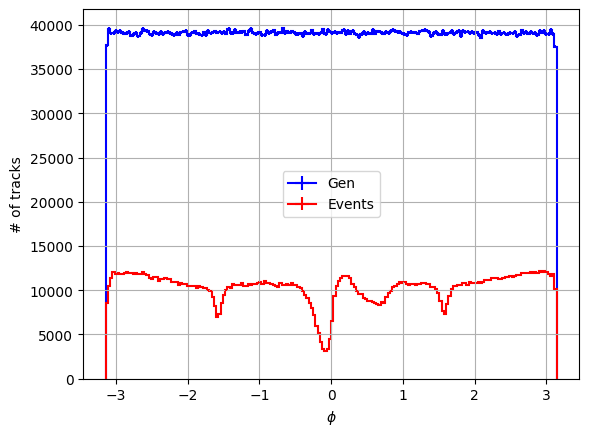

In [74]:
hPhiGen.plot(color = "blue", label = "Gen")
hPhiEvents.plot(color = "red", label = "Events")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

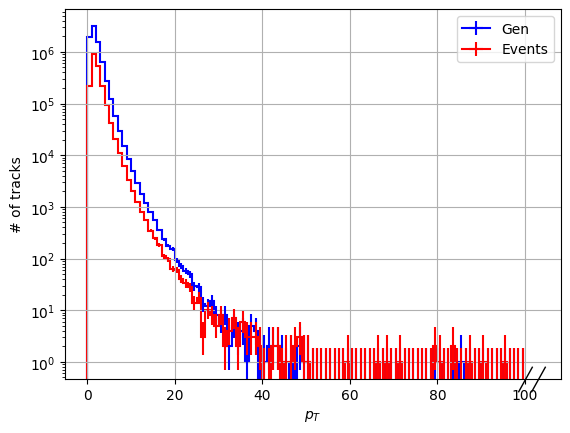

In [75]:
hPtGen.plot(color = "blue", label = "Gen")
hPtEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

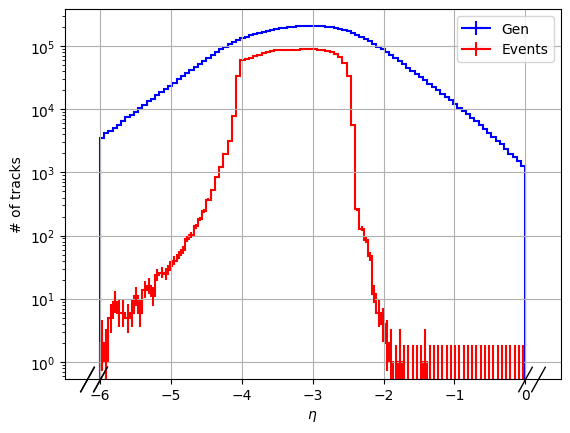

In [76]:
hEtaGen.plot(color = "blue", label = "Gen")
hEtaEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

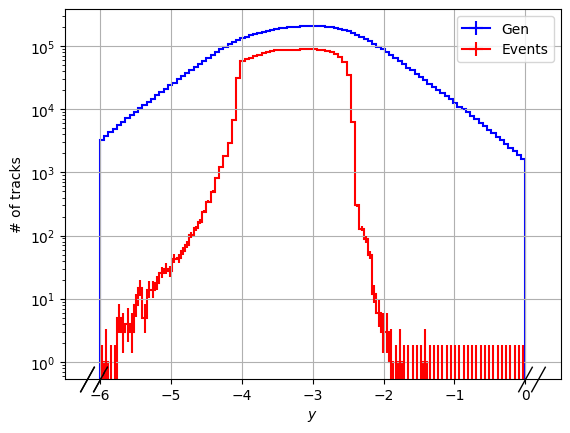

In [77]:
hYGen.plot(color = "blue", label = "Gen")
hYEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

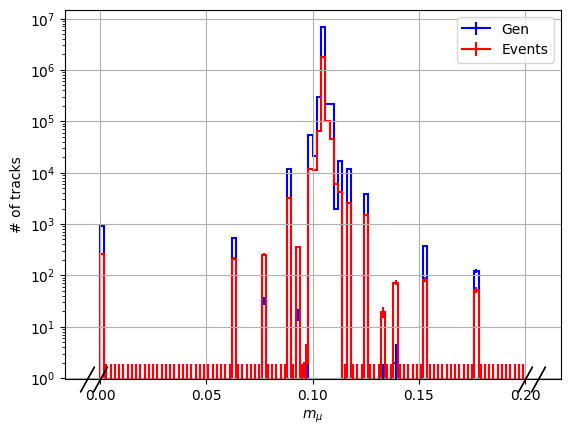

In [78]:
hMassGen.plot(color = "blue", label = "Gen")
hMassEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

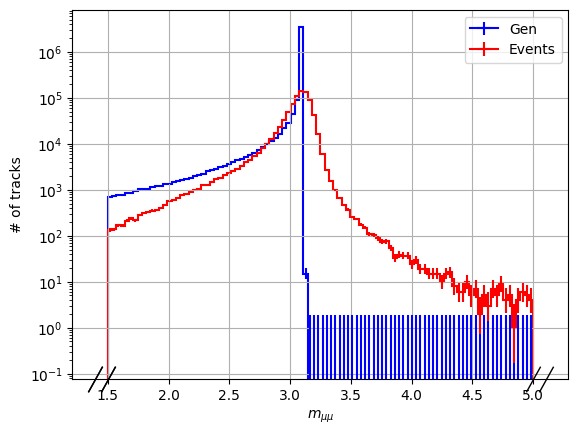

In [79]:
hMass2Gen.plot(color = "blue", label = "Gen")
hMass_OSEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

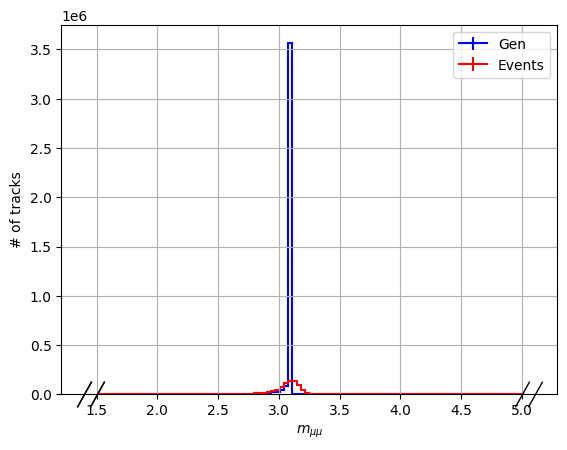

In [80]:
hMass2Gen.plot(color = "blue", label = "Gen")
hMass_OSEvents.plot(color = "red", label = "Events")
#plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [71]:
print(hMass_OSEvents.axes[0].centers.tolist())
print(hMass_OSEvents.view().tolist())

[1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 4.4925000